# MNIST: Introduction to CNN Keras

* **1. Introduction**
* **2. Data preparation**
    * 2.1 Load data
    * 2.2 Normalization
    * 2.3 Reshape
    * 2.4 Label encoding
    * 2.5 Split training and valdiation set
* **3. Convolution Neural Network**
    * 3.1 Define the model
    * 3.2 Data augmentation
    * 3.3 Model training
* **4. Evaluate the model**
    * 4.1 Training and validation curves
* **5. Prediction and submition**
    * 5.1 Prediction validation results
    * 5.2 Submition
* **6. References**
* **7. Sklearn Soluation**

# 1. Introduction

This kernel is your start in deep learning.

MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. A new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.  In this competition, your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. We’ve curated a set of tutorial-style kernels which cover everything from regression to neural networks. We encourage you to experiment with different algorithms to learn first-hand what works well and how techniques compare.

**Import all Necessary Libraries**

In [42]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from keras.layers import BatchNormalization

from keras.preprocessing.image import ImageDataGenerator

from keras.utils.np_utils import to_categorical

#from keras.datasets import mnist

# 2. Data preparation
## 2.1 Load data

**Set data features and labels**

In [16]:
(X, y), (test_x, test_y) = mnist.load_data()
assert X.shape == (60000, 28, 28)
assert test_x.shape == (10000, 28, 28)
assert y.shape == (60000,)
assert test_y.shape == (10000,)

print("Data are Ready!!")


Data are Ready!!


## 2.2 Normalization

We perform a grayscale normalization to reduce the effect of illumination's differences. 

Moreover the CNN converg faster on [0..1] data than on [0..255].

In [17]:
X = X / 255.0
test_x = test_x / 255.0

## 2.3 Reshape

In [18]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
# canal = 1 => For gray scale
X = X.reshape(-1,28,28,1)
test_x = test_x.reshape(-1,28,28,1)

## 2.4 Label encoding

**One-Hot Encoding**

In [19]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y = to_categorical(y)

print(f"Label size {y.shape}")

Label size (60000, 10)


Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

## 2.5 Split training and valdiation set

In [20]:
# Split the train and the validation set for the fitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((54000, 28, 28, 1), (6000, 28, 28, 1), (54000, 10), (6000, 10))

I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

**Data Visualization**

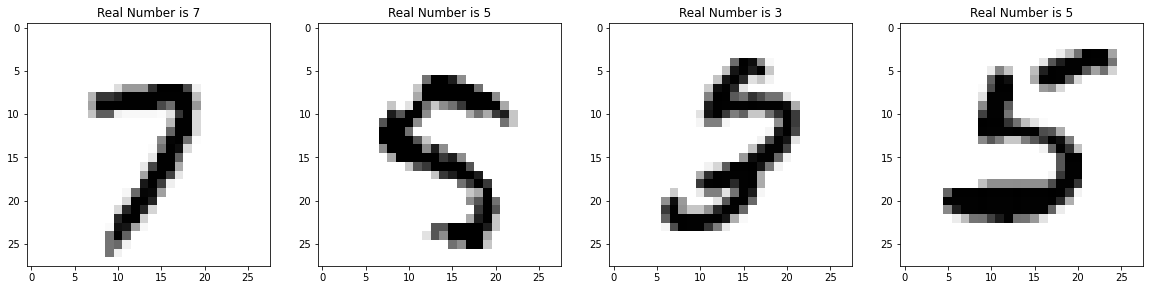

In [22]:
X_train__ = X_train.reshape(X_train.shape[0], 28, 28)

fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train__[i], cmap='binary')
    digit = y_train[i].argmax()
    ax.set(title = f"Real Number is {digit}");

**Normalization**

In [23]:
mean = np.mean(X_train)
std = np.std(X_train)

def standardize(x):
    return (x-mean)/std

# 3. CNN
## 3.1 Define the model

I used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 32 filters for the two firsts conv2D layers and 64 filters for the two second layers and 128 filters for two third layers and 256 for the last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important. 

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network. 

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

**Model Definition**

In [24]:
model=Sequential()

#model.add(Lambda(standardize,input_shape=(28,28,1)))    
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())    
model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
    
model.add(MaxPooling2D(pool_size=(2,2)))
    
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512,activation="relu"))
    
model.add(Dense(10,activation="softmax"))
    
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

## 3.2 Data augmentation

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the number is not centered 
The scale is not the same (some who write with big/small numbers)
The image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. 

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

The improvement is important : 
   - Without data augmentation i obtained an accuracy of 98.114%
   - With data augmentation i achieved 99.67% of accuracy

In [25]:
epochs = 5
batch_size = 64

In [26]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=batch_size)
test_gen = datagen.flow(X_test, y_test, batch_size=batch_size)

For the data augmentation, i choosed to :
   - Randomly rotate some training images by 10 degrees
   - Randomly  Zoom by 10% some training images
   - Randomly shift images horizontally by 10% of the width
   - Randomly shift images vertically by 10% of the height
   
I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Once our model is ready, we fit the training dataset .

## 3.3 Model training

In [27]:
# This make accuarcy 0.998
#model.fit(X, y, batch_size=batch_size, validation_split=0.2, epochs=10)

In [28]:
# Fit the model
history = model.fit(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              validation_data = test_gen,
                              validation_steps = X_test.shape[0] // batch_size)

Epoch 1/5
843/843 [==============================] - 36s 42ms/step - loss: 0.1321 - accuracy: 0.9587 - val_loss: 0.0958 - val_accuracy: 0.9693
Epoch 2/5
843/843 [==============================] - 35s 41ms/step - loss: 0.0636 - accuracy: 0.9812 - val_loss: 0.0509 - val_accuracy: 0.9844
Epoch 3/5
843/843 [==============================] - 35s 41ms/step - loss: 0.0514 - accuracy: 0.9846 - val_loss: 0.0639 - val_accuracy: 0.9814
Epoch 4/5
843/843 [==============================] - 35s 42ms/step - loss: 0.0453 - accuracy: 0.9858 - val_loss: 0.0521 - val_accuracy: 0.9840
Epoch 5/5
843/843 [==============================] - 35s 41ms/step - loss: 0.0385 - accuracy: 0.9886 - val_loss: 0.0400 - val_accuracy: 0.9887


**Plot CNN model**

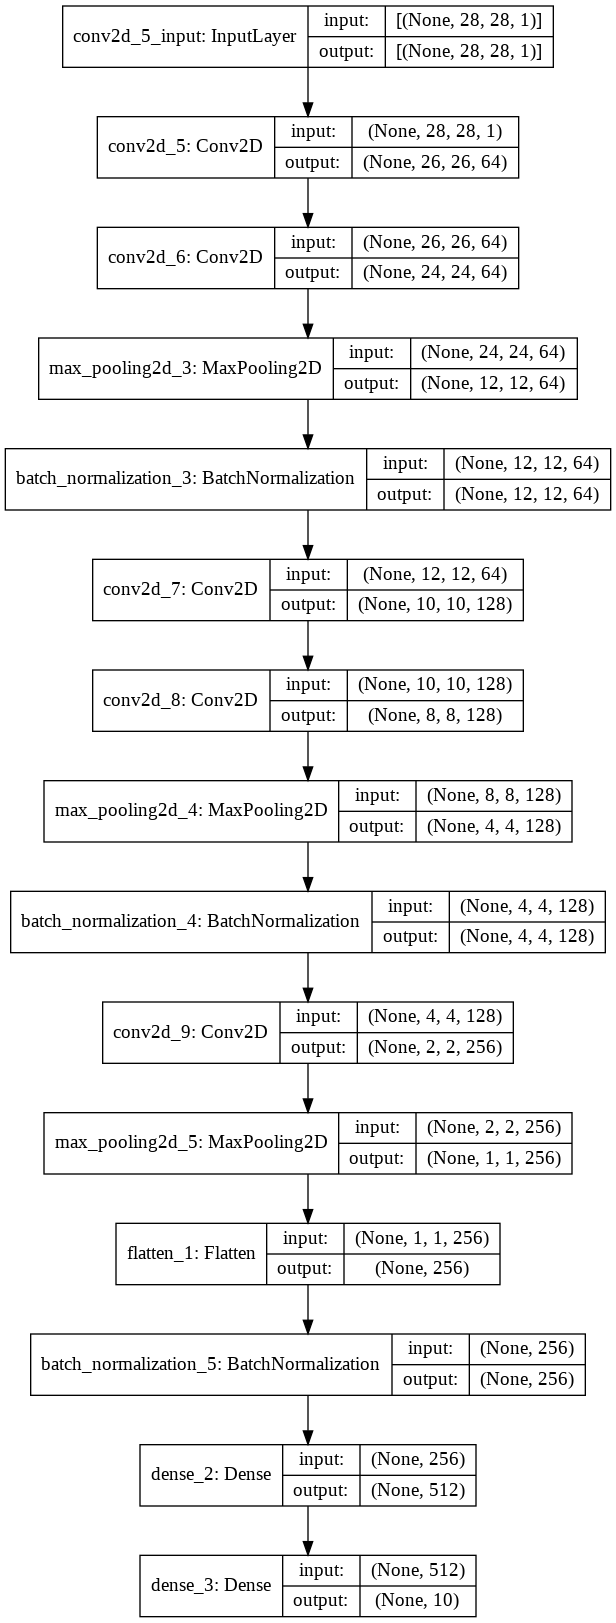

In [29]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# 4. Evaluate the model
## 4.1 Training and validation curves

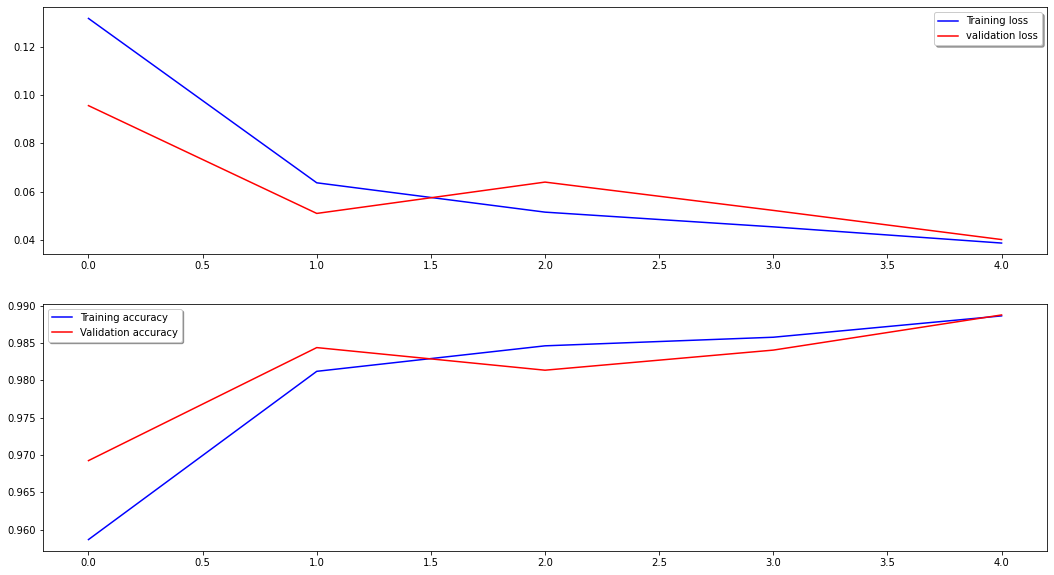

In [34]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 4.2 Visualizing feature layers

It can be insightfull to visualise the model layers to see the features the model has learned.

The code below lets us see the features in the model.

In [90]:
layer_names = [layer.name for layer in model.layers]
layer_outputs = [layer.output for layer in model.layers]
feature_map_model = Model(inputs=model.input, outputs=layer_outputs)
test_digit = test_x[0]
feature_maps = feature_map_model.predict(np.expand_dims(test_digit, axis=0))

def display_activation(activation, title, col_size, row_size): 
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    fig.suptitle(title)
    for row in range(0,row_size):
        for col in range(0,col_size):
            # ax[row][col].set_title(title)
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

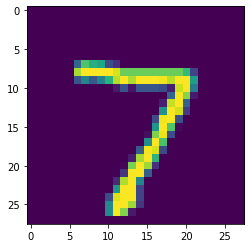

In [88]:
plt.imshow(test_digit[:,:,0]);


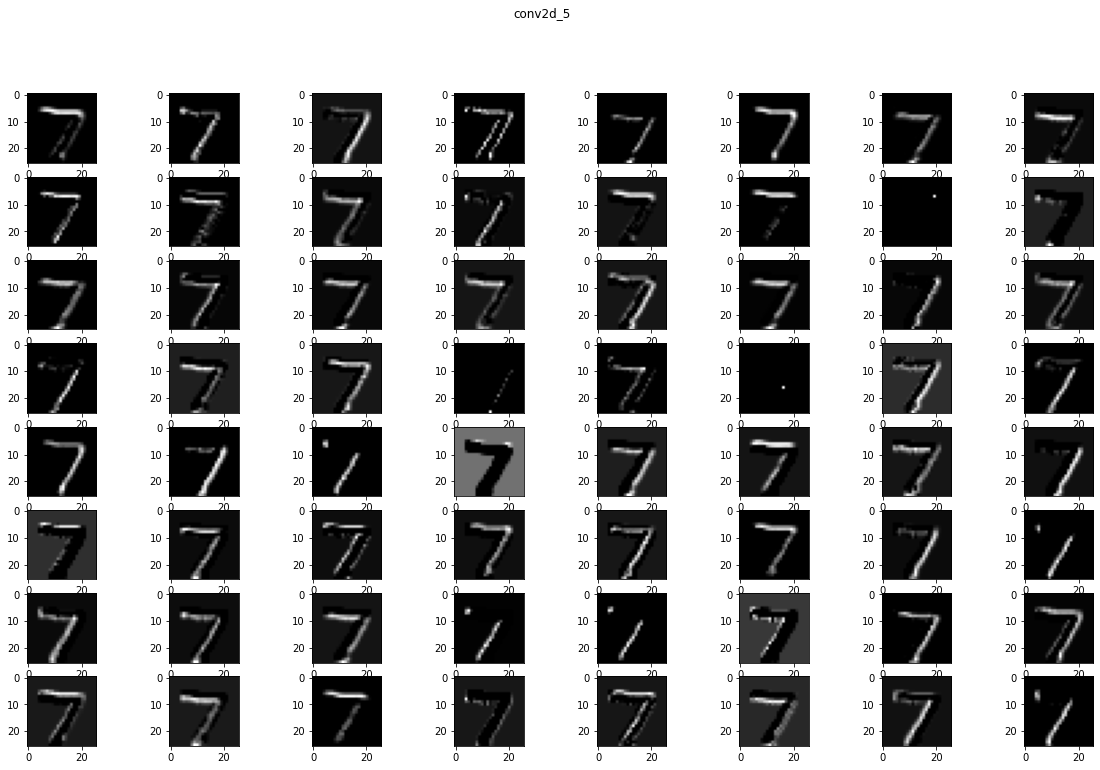

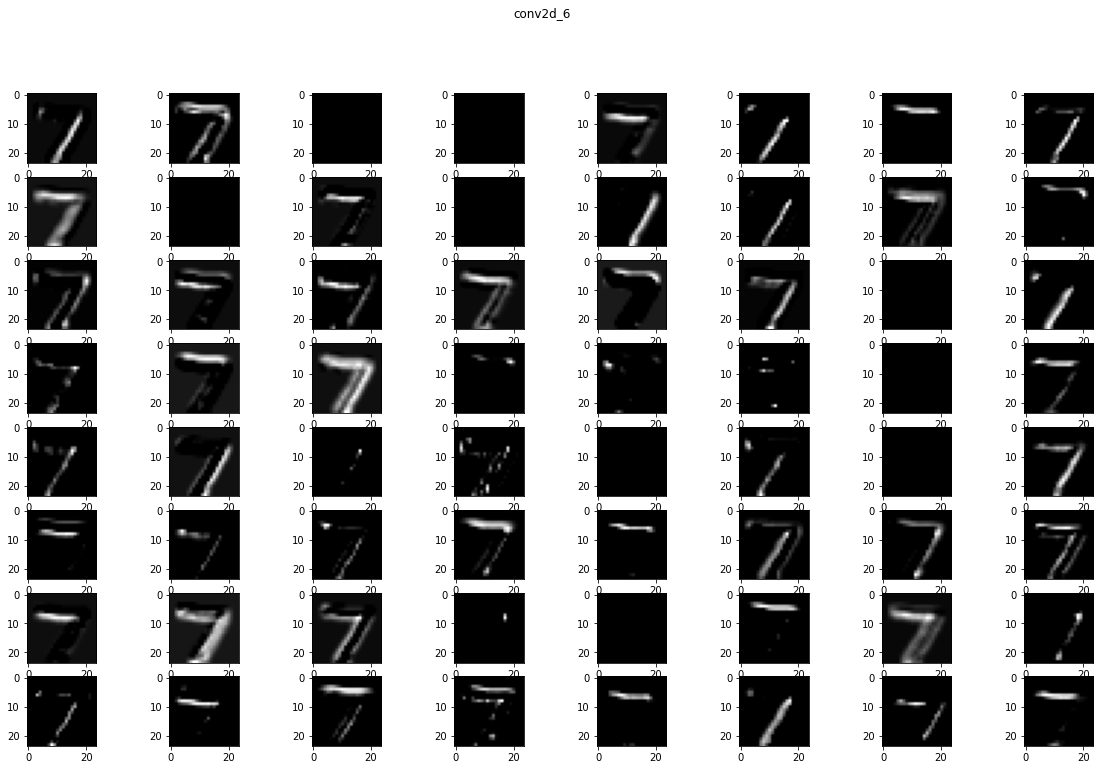

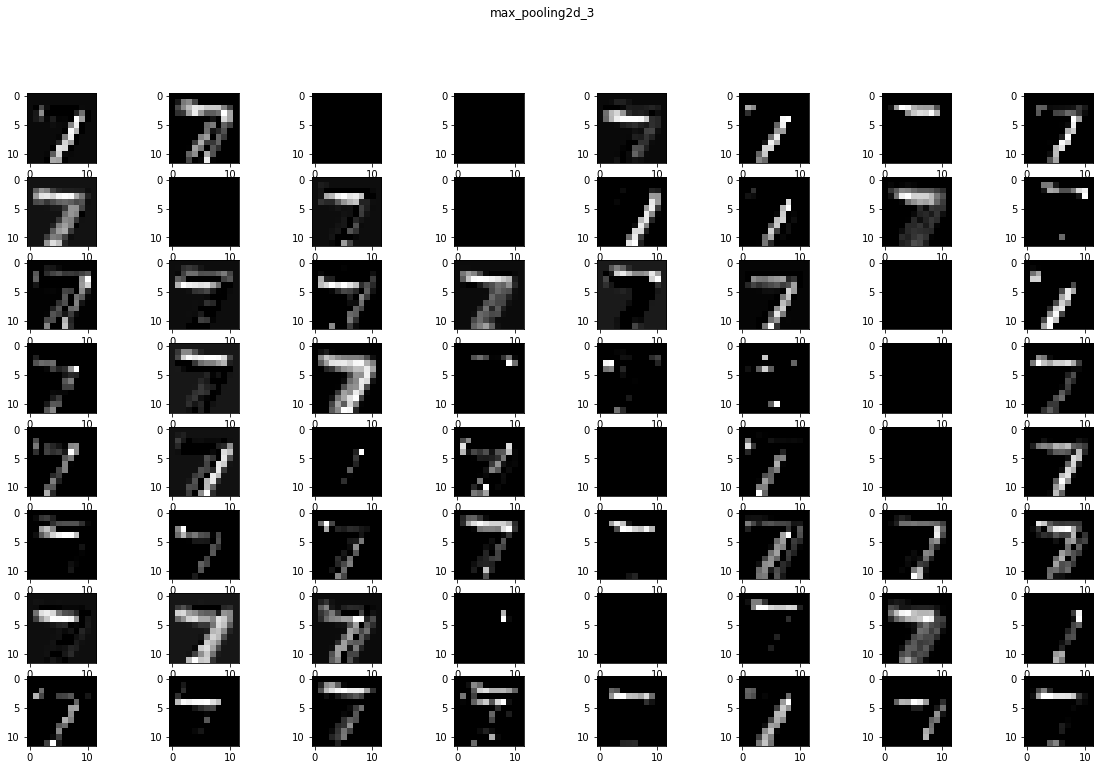

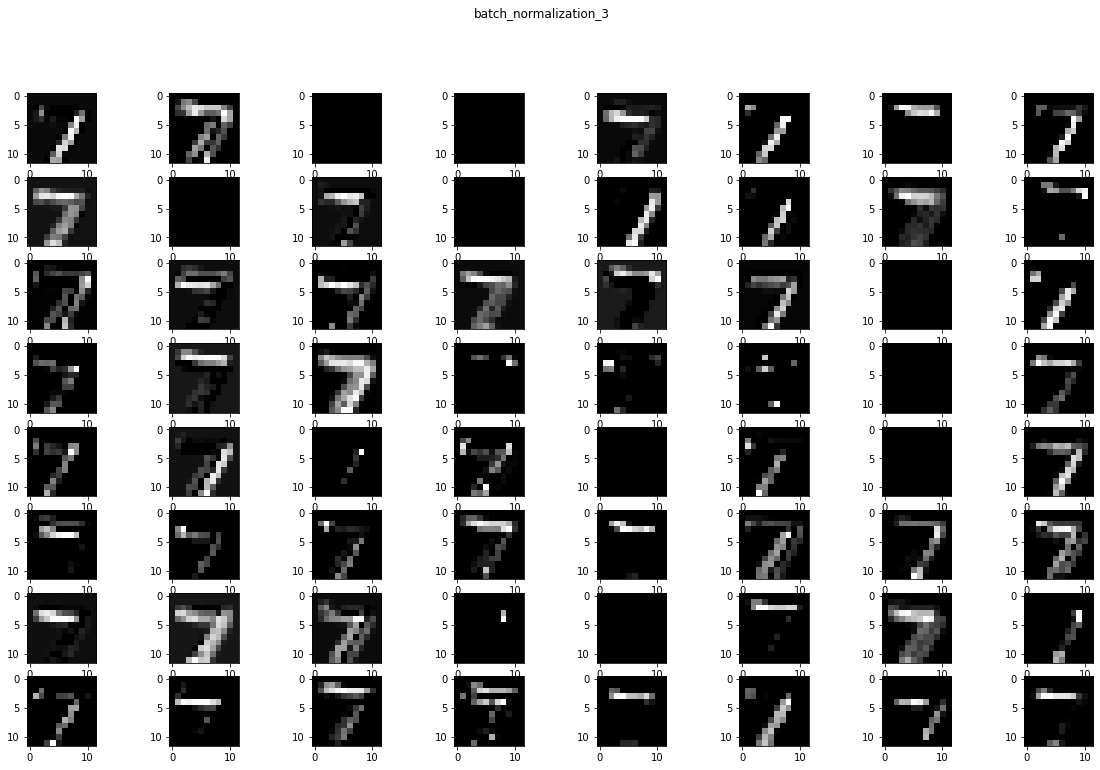

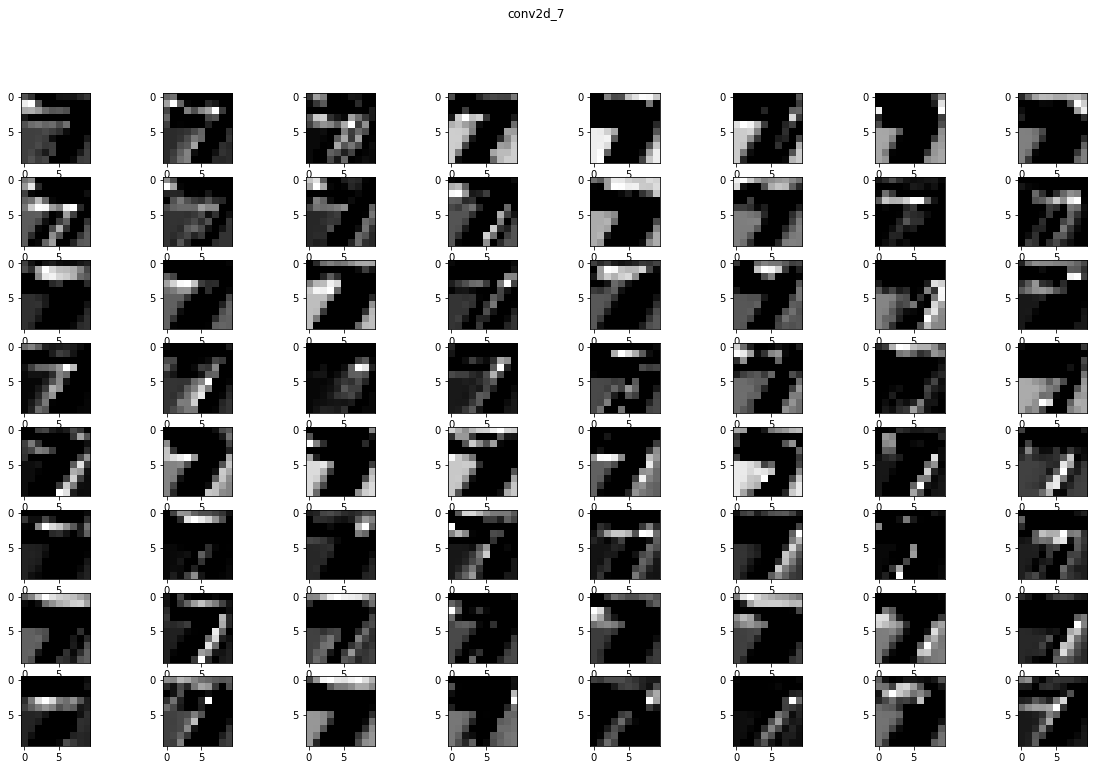

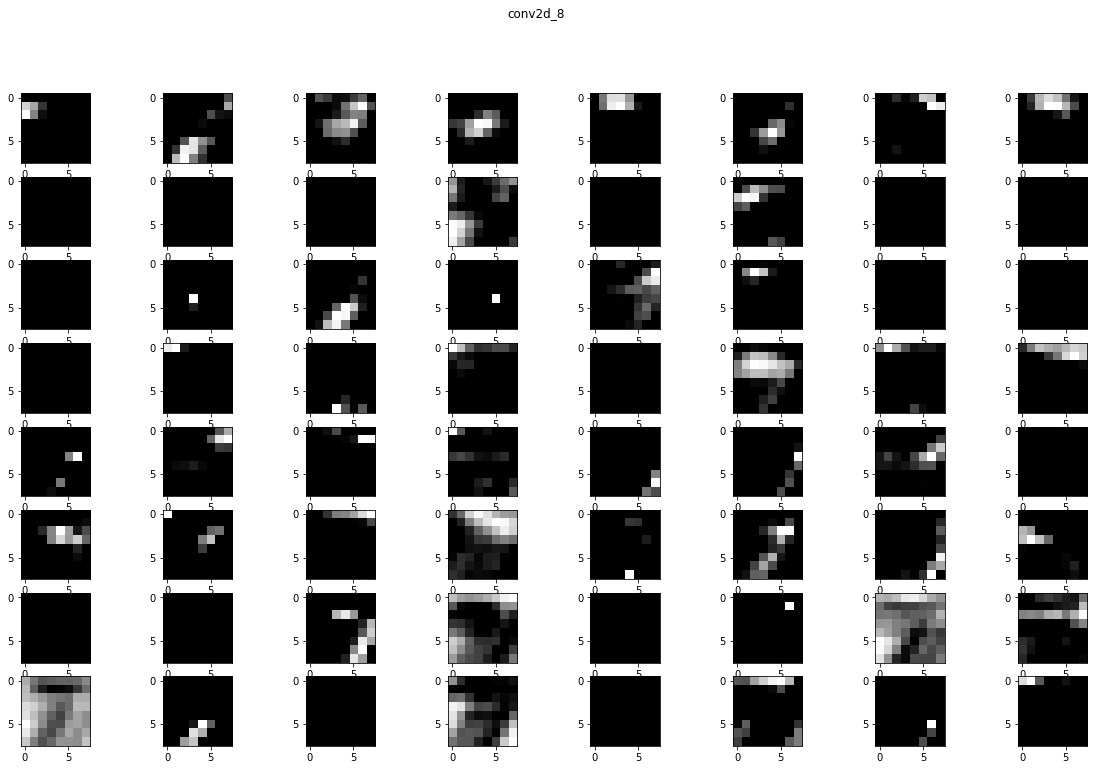

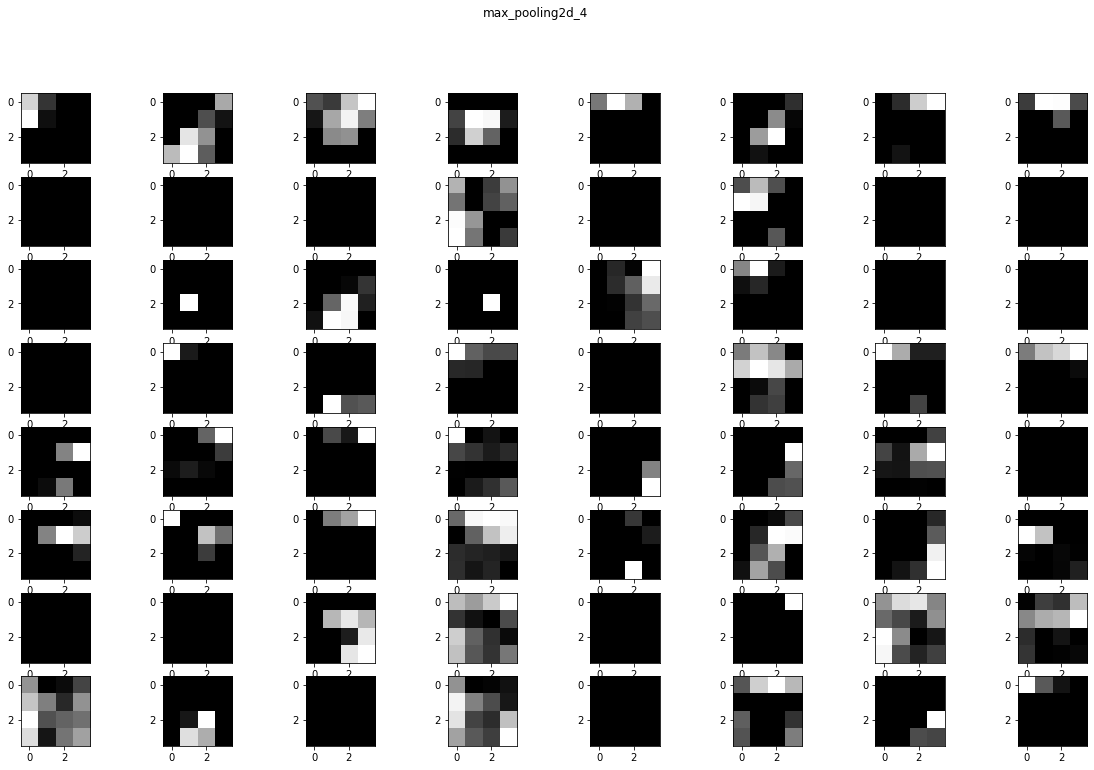

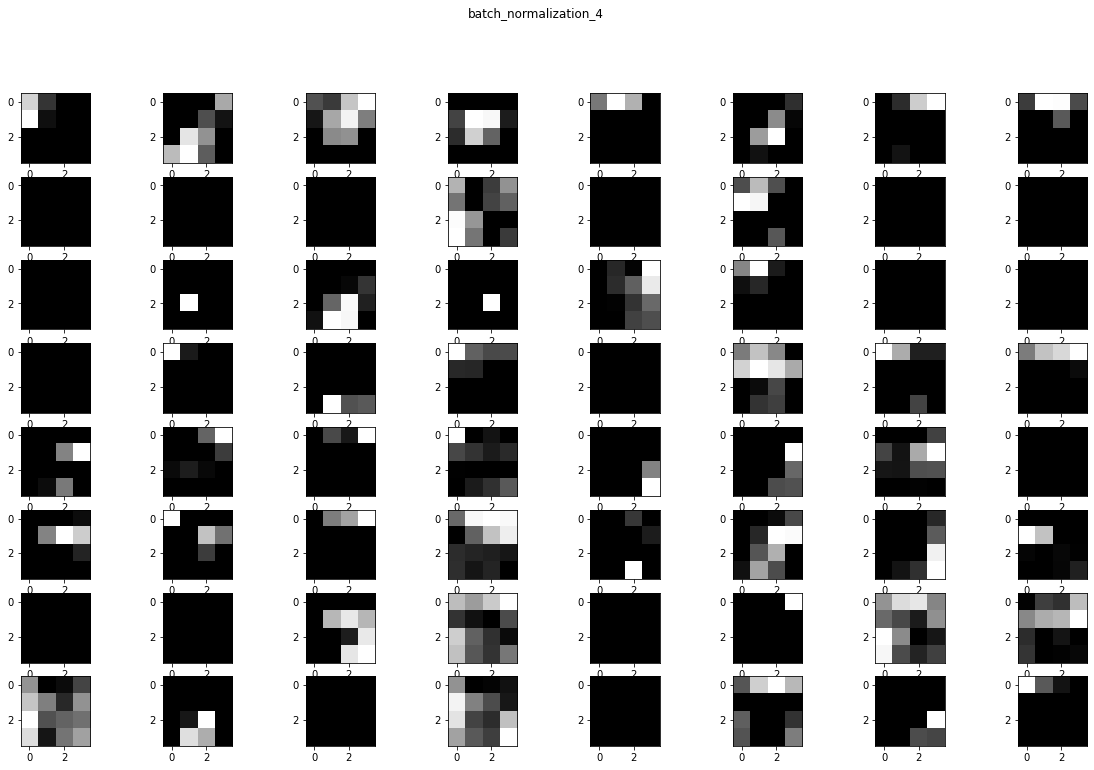

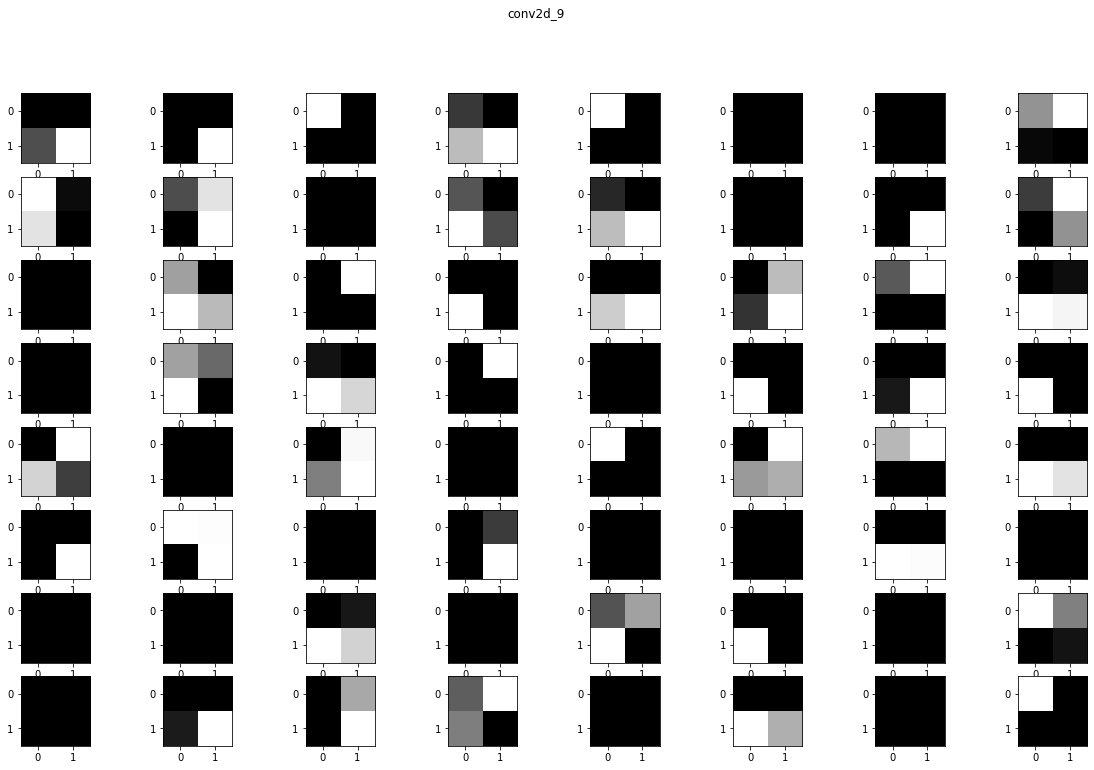

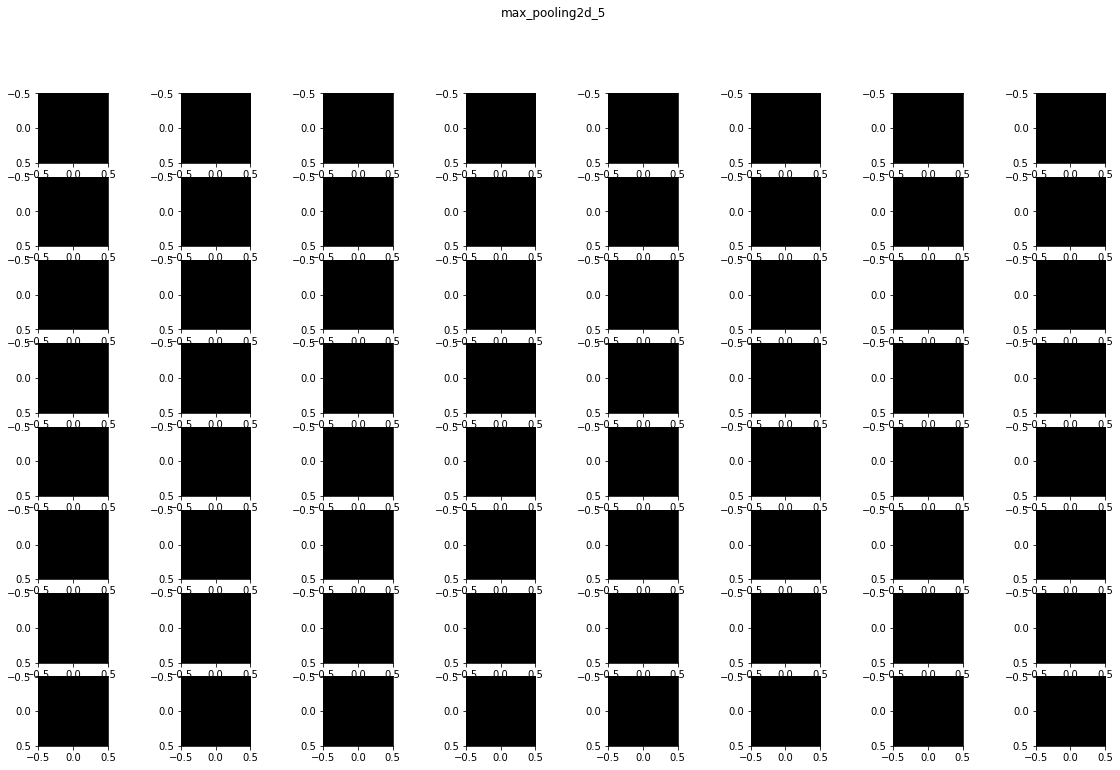

In [91]:
for index, (layer_name, feature_map) in enumerate(zip(layer_names, feature_maps)):  
  if len(feature_map.shape) == 4:

    display_activation(feature_map,layer_name, 8, 8)


IndexError: ignored

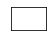

In [43]:
from matplotlib import pyplot
feature_maps = model.predict(X_test)
# plot the output from each block
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = pyplot.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
			ix += 1
	# show the figure
	pyplot.show()

# 5. Prediction and submition

## 5.1 Prediction validation results

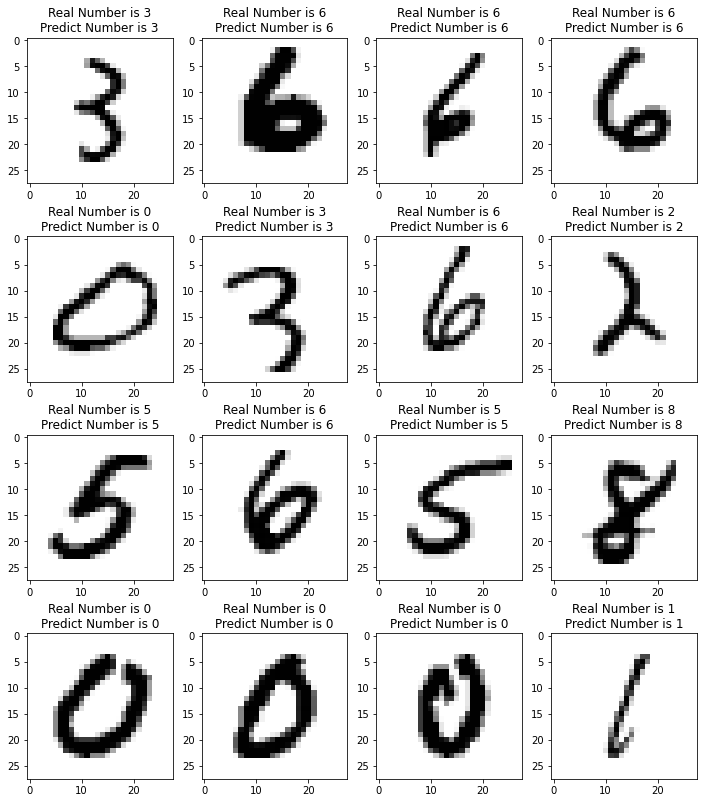

In [36]:
y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");

# 6. References

1. https://keras.io/models/sequential/
2. https://keras.io/layers/core/
3. https://keras.io/layers/convolutional/
4. https://keras.io/layers/pooling/
5. https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6